In [99]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [100]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams["font.family"]="BM YEONSUNG"

# Bostan home price predict

In [101]:
D=pd.read_excel("http://data.hossam.kr/E04/boston.xlsx")
data=pd.DataFrame(D)

In [102]:
data.rename(columns={'CAT. MEDV':"CAT"},inplace=True)

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
 14  CAT      506 non-null    int64  
dtypes: float64(11), int64(4)
memory usage: 59.4 KB


In [104]:
target='MEDV'
feature=data.columns.difference([target])

## 데이터 시각화 및 전처리

- 1. Nan값은 존재하지않음
- 2. 데이터를 시각화해서 범주형 데이터를 확인해보자

In [105]:
# plt.figure()
# sb.pairplot(data=data[feature])

In [106]:
category=["CAT","CHAS"]
numeric=[col for col in feature if col not in category]

## 범주형 데이터 확인

In [107]:
# 범주형 데이터 확인
data["CAT"].value_counts()

CAT
0    422
1     84
Name: count, dtype: int64

In [108]:
data["CHAS"].value_counts()

CHAS
0    471
1     35
Name: count, dtype: int64

## 연속형 데이터 확인

c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na 

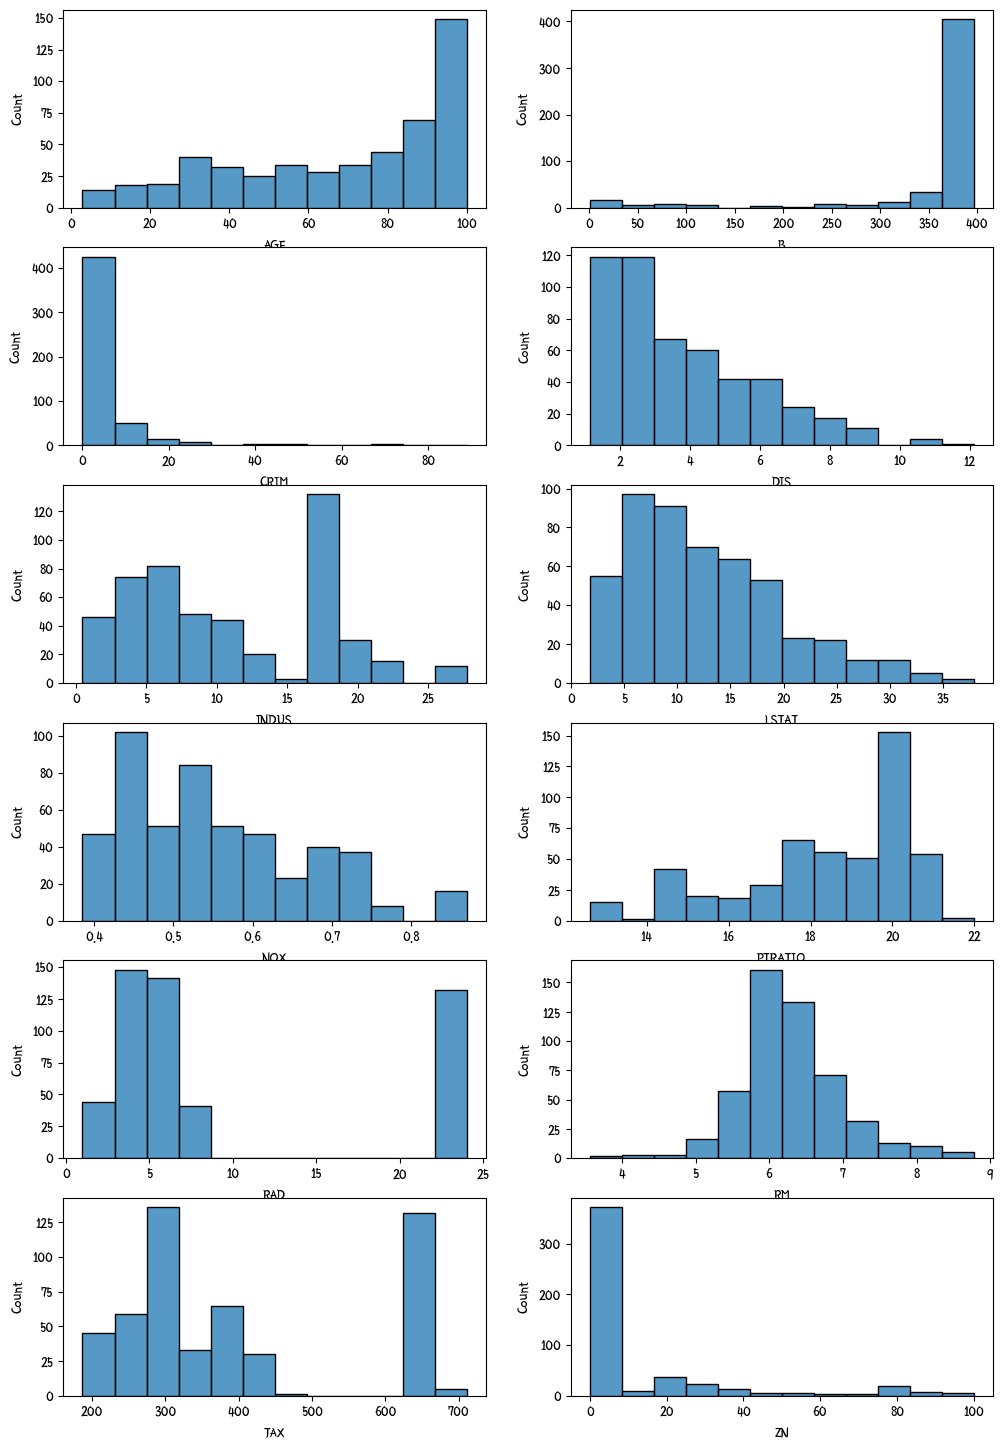

In [109]:
f,a=plt.subplots(len(numeric)//2,2,figsize=(12,(len(numeric)//2)*3))
a_l=sum(list(map(list,a.squeeze())),[])
for col in numeric:
    sb.histplot(data=data[col],bins=12,ax=a_l[numeric.index(col)])

c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

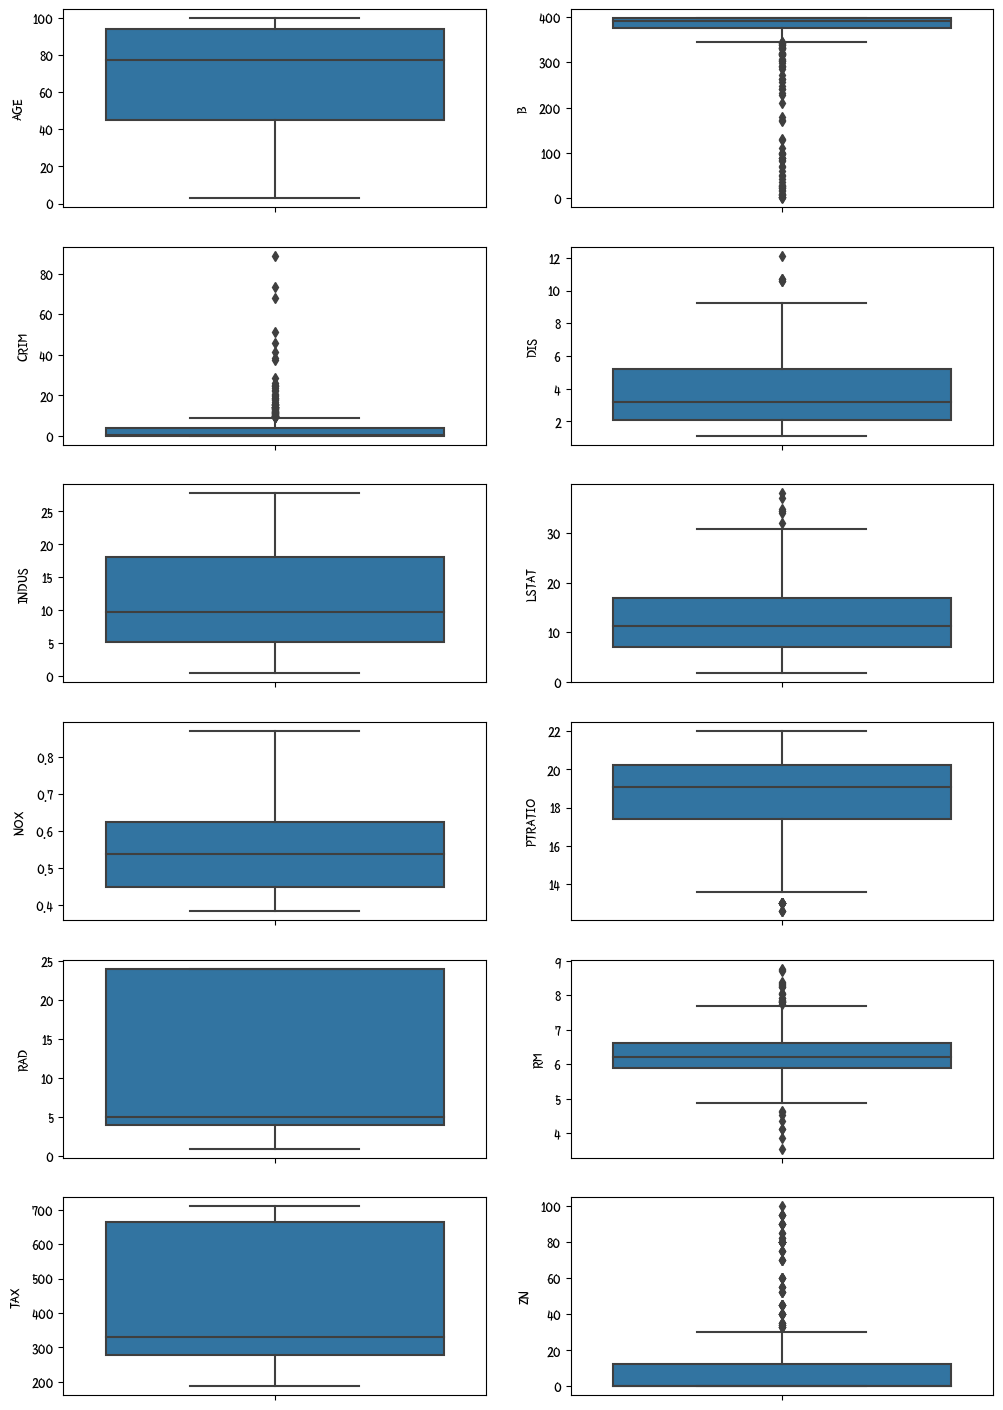

In [110]:
f,a=plt.subplots(len(numeric)//2,2,figsize=(12,(len(numeric)//2)*3))
a_l=sum(list(map(list,a.squeeze())),[])
for col in numeric:
    sb.boxplot(data=data,y=col,ax=a_l[numeric.index(col)])

### 위의 결과를 보아하니 다음과 같은 feature들의 분포가 굉장히 불균형함
- B, Crime, ZN
- 이들은 비모수적 방법을 통해 데이터를 처리하는게 좋아보임 + 데이터간 `ragne`가 굉장히 다름
- 기본적으로 범위를 같게 맞춰주기 위해 scalin(minmax)를 이용하겠음

## 데이터 PreProcessiong


### 이상치 제거 및 범주화

#### B
이상치=0            
그외=1

In [111]:
import statsmodels.api as sm

In [112]:
iqr=data["B"].quantile(0.75)-data["B"].quantile(0.25)
temp=data["B"].quantile(0.5)-1.5*iqr

In [113]:
data.loc[data["B"]<=temp,"B"]=0
data.loc[data["B"]>temp,"B"]=1
data["B"].value_counts()

B
1.0    410
0.0     96
Name: count, dtype: int64

#### Crim
위와 마찬가지

In [114]:
iqr=data["CRIM"].quantile(0.75)-data["CRIM"].quantile(0.25)
temp=data["CRIM"].quantile(0.5)+1.5*iqr

In [115]:
data.loc[data["CRIM"]<=temp,"CRIM"]=0
data.loc[data["CRIM"]>temp,"CRIM"]=1
data["CRIM"].value_counts()

CRIM
0.0    405
1.0    101
Name: count, dtype: int64

#### ZN

In [116]:
iqr=data["ZN"].quantile(0.75)-data["ZN"].quantile(0.25)
temp=data["ZN"].quantile(0.5)+1.5*iqr

In [117]:
data.loc[data["ZN"]<=temp,"ZN"]=0
data.loc[data["ZN"]>temp,"ZN"]=1
data["ZN"].value_counts()

ZN
0.0    384
1.0    122
Name: count, dtype: int64

#### 유의사항
지나치게 단순화 시켜 데이터 소실의 위험이 있으며, `pd.qcut`을 이용하여 데이터를 분할하는 방법도 차후 고려해봐야함

#### 시각화로 확인 후 마무리

c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

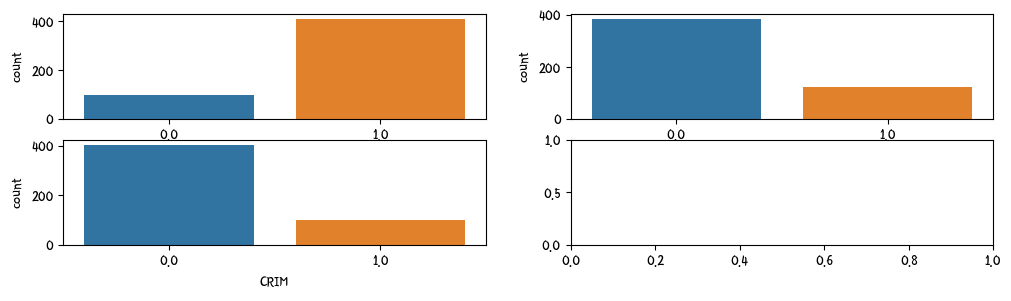

In [118]:
change_col=["B","ZN","CRIM"]
f,a=plt.subplots(len(change_col)//2+1,2,figsize=(12,(len(change_col)//2)*3))
a_l=sum(list(map(list,a.squeeze())),[])
for col in change_col:
    sb.countplot(data=data,x=col,ax=a_l[change_col.index(col)])
plt.show()
plt.close()

In [119]:
for col in change_col:
    category.append(col)
    numeric.remove(col)

In [120]:
print(category)
print(numeric)

['CAT', 'CHAS', 'B', 'ZN', 'CRIM']
['AGE', 'DIS', 'INDUS', 'LSTAT', 'NOX', 'PTRATIO', 'RAD', 'RM', 'TAX']


### 연속형 변수들의 기본적인 처리
평균을 중심으로 대칭이면 좋고, 일단 값의 범위가 통일되어야 모델의 성능이 향상될 것으로 기대         

#### 1. AGE, PTRATIO
- 왼쪽으로 긴 꼬리

In [121]:
# 이 근거로 log 변환을 실시할 수 없음
print('"AGE=0" :',data.loc[data["AGE"]==0,"AGE"].count())
print('"AGE=0" :',data.loc[data["PTRATIO"]==0,"PTRATIO"].count())

"AGE=0" : 0
"AGE=0" : 0


In [122]:
import scipy as sp

c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na 

<Axes: xlabel='PTRATIO', ylabel='Count'>

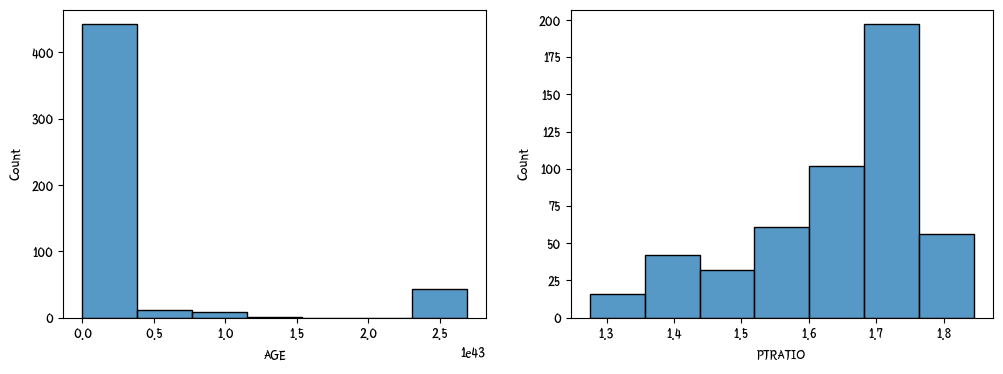

In [123]:
_,a=plt.subplots(1,2,figsize=(12,4))
sb.histplot(data["AGE"].apply(lambda x:np.exp(x)),bins=7,ax=a[0]) #지수변환
sb.histplot(data["PTRATIO"].apply(lambda x:(x**(1/2)-1)/2),bins=7,ax=a[1]) # boxcox 변환

위와 같은 변환을 실시해도 데이터의 분포상 평균을 중심으로 대칭시키기 쉽지 않음
> 이 부분에 대한 공부가 더 필요함 ㅜㅜ 따라서 그대로 사용하기로 함

#### 2. DIS, LSTAT
오른쪽으로 긴 꼬리

c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na 

<Axes: xlabel='LSTAT', ylabel='Count'>

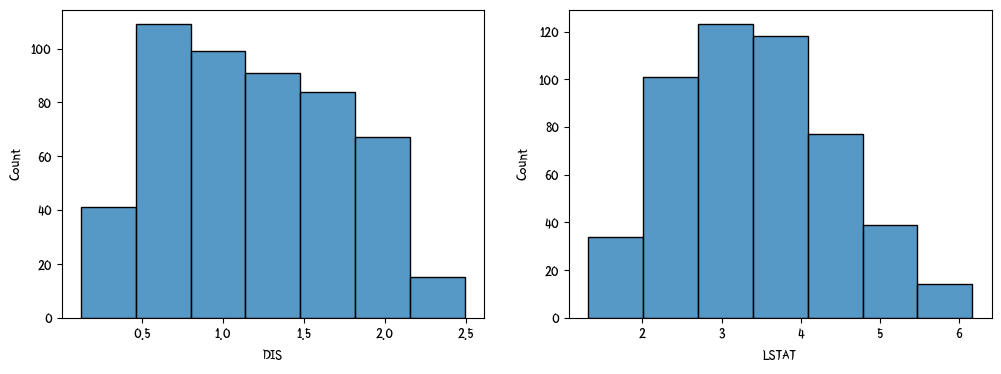

In [124]:
_,a=plt.subplots(1,2,figsize=(12,4))
sb.histplot(data["DIS"].apply(lambda x:np.log(x)),bins=7,ax=a[0]) #로그변환
sb.histplot(data["LSTAT"].apply(lambda x:x**(1/2)),bins=7,ax=a[1]) #지수변환

In [125]:
data["DIS"]=data["DIS"].apply(lambda x:np.log(x))
data["LSTAT"]=data["LSTAT"].apply(lambda x:x**(1/2))

### 연속형 변수의 정규화 처리 : Min_Max

In [126]:
# 차후 예측을 위해서 min,max를 기억하는 딕셔너리를 만들어두면 좋겠지만
import sklearn.preprocessing as skpre
data[numeric]=skpre.minmax_scale(data[numeric])

In [127]:
data[numeric].describe()

,AGE,DIS,INDUS,LSTAT,NOX,PTRATIO,RAD,RM,TAX
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,0.676364,0.449191,0.391378,0.433777,0.349167,0.622929,0.371713,0.521869,0.422208
std,0.289896,0.227318,0.251479,0.203679,0.238431,0.230313,0.378576,0.134627,0.321636
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.433831,0.261281,0.173387,0.272554,0.131687,0.510638,0.130435,0.445392,0.175573
50%,0.768280,0.439687,0.338343,0.424035,0.314815,0.686170,0.173913,0.507281,0.272901
75%,0.938980,0.642307,0.646628,0.578199,0.491770,0.808511,1.000000,0.586798,0.914122
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## feature selection
비선형을 가정하기 때문에 선형관계를 가정한 피어슨 상관계수를 사용하기 굉장히 난감함

이후 시행할 데이터 분리에서 층화추출법을 이용하기 해서는 어떤 방법이 있을까?            
-> 학습에 있어 균형적인 데이터를 주기 위해서

#### 다음과 같은 방법을 생각해보자
- 연속형 데이터
    * 1. pca
    * 2. vif

In [128]:
import sklearn.decomposition as skdec

In [129]:
# 주성분을 4로 설정한 이유 : eigen value를 보고 중요도를 보고 결정할 것이기 때문
pca=skdec.PCA(n_components=4)
pca.fit(data[numeric])

PCA(n_components=4)

In [130]:
pd.DataFrame(list(zip([f"P{x}" for x in range(1,5)],pca.explained_variance_))).rename(columns=dict(zip([0,1],["주성분","eigen_value"])))

,주성분,eigen_value
0,P1,0.399953
1,P2,0.085339
2,P3,0.046627
3,P4,0.026682


위의 현상을 보아 주성분들이 numeric feature들의 원래 분산을 제대로 설명하지 못함.           
이와 같은 경우 다음과 같은 차원축소는 권장되지 않음

In [142]:
import statsmodels.api as sm

In [158]:
while True:
    vif_result=[]
    for x in numeric:
        sub={"col":x}
        ex,en=[col for col in numeric if col!=x],[x]
        temp=sm.OLS(exog=data[ex],endog=data[en]).fit()
        sub['vif']=1/(1-temp.rsquared)
        vif_result.append(sub)
    temp_result=pd.DataFrame(vif_result).sort_values(by="vif",ascending=False)
    if temp_result.iloc[0]["vif"]>10:
        numeric.remove(temp_result.iloc[0]["col"])
    else:
        break

In [159]:
temp_result

,col,vif
1,INDUS,9.372859
2,LSTAT,9.121819
3,NOX,8.976786
4,RAD,3.404047
0,DIS,2.198998


위와 같은 feature들이 다중공선성을 제거한 feature(numeric)이나 data에 있어서 지나치게 제거되었을 가능성이 있음.         
그러나 학습속도를 올리기 위해 위의 feature들을 선택하겠음

## 데이터 분리 및 학습모델 생성

In [132]:
import sklearn.model_selection as skmod
np.random.seed(10)

#### 데이터 분리

In [133]:
train,test=skmod.train_test_split(data,train_size=0.7,random_state=10)

#### 모델 만들기

In [134]:
import tensorflow.keras as keras

In [171]:
def ANN_model(number):
    model=keras.Sequential()
    model.add(keras.layers.Dense(len(numeric+category),activation='relu',input_shape=(len(numeric+category),))) # 입력레이어
    model.add(keras.layers.Dense(number,activation='linear'))
    model.add(keras.layers.Dense(1,activation="linear")) # 출력레이어
    model.compile(optimizer='adam',loss='mse',metrics=["mse"])
    return model

In [172]:
ANN_models={}
for num in range(2,len(numeric+category)-1):
    ANN_models[num]=ANN_model(num)

In [173]:
ANN_models[2].summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_159 (Dense)           (None, 10)                110       
                                                                 
 dense_160 (Dense)           (None, 2)                 22        
                                                                 
 dense_161 (Dense)           (None, 1)                 3         
                                                                 
Total params: 135 (540.00 Byte)
Trainable params: 135 (540.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 본격적인 학습

In [174]:
results={}
for num in ANN_models:
    results[num]=ANN_models[num].fit(x=train[numeric+category],y=train[target],epochs=300,validation_data=(test[numeric+category],test[target]),callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,verbose=1)])

Epoch 1/300
12/12 [==============================] - 1s 15ms/step - loss: 557.5278 - mse: 557.5278 - val_loss: 658.5541 - val_mse: 658.5541
Epoch 2/300
12/12 [==============================] - 0s 5ms/step - loss: 546.5215 - mse: 546.5215 - val_loss: 647.0425 - val_mse: 647.0425
Epoch 3/300
12/12 [==============================] - 0s 5ms/step - loss: 535.6893 - mse: 535.6893 - val_loss: 635.7882 - val_mse: 635.7882
Epoch 4/300
12/12 [==============================] - 0s 4ms/step - loss: 525.1493 - mse: 525.1493 - val_loss: 624.4954 - val_mse: 624.4954
Epoch 5/300
12/12 [==============================] - 0s 5ms/step - loss: 514.4009 - mse: 514.4009 - val_loss: 613.0383 - val_mse: 613.0383
Epoch 6/300
12/12 [==============================] - 0s 5ms/step - loss: 503.5064 - mse: 503.5064 - val_loss: 601.6964 - val_mse: 601.6964
Epoch 7/300
12/12 [==============================] - 0s 6ms/step - loss: 492.6052 - mse: 492.6052 - val_loss: 590.0394 - val_mse: 590.0394
Epoch 8/300
12/12 [=======

### 학습결과

In [177]:
pd.DataFrame([{"은닉층":x,"val_mse":results[x].history["val_mse"][-1]} for x in range(2,len(numeric+category)-1)]).sort_values(by="val_mse").T

,3,5,6,0,2,1,4
은닉층,5.000000,7.000000,8.000000,2.000000,4.000000,3.00000,6.000000
val_mse,16.936224,18.463596,19.199396,20.264141,20.486275,21.47522,22.510847


따라서 은닉층이 3개인 모델이 test데이터를 예측할 때 가장 작은 mse값을 가짐(MSE)

#### 시각화 해서 알아보자

In [178]:
results[3].history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

In [180]:
train["pred_MEDV_2"]=ANN_models[3].predict(train[numeric+category])
test["pred_MEDV_2"]=ANN_models[3].predict(test[numeric+category])

5/5 [==============================] - 0s 1ms/step


c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na 

<Axes: ylabel='MEDV'>

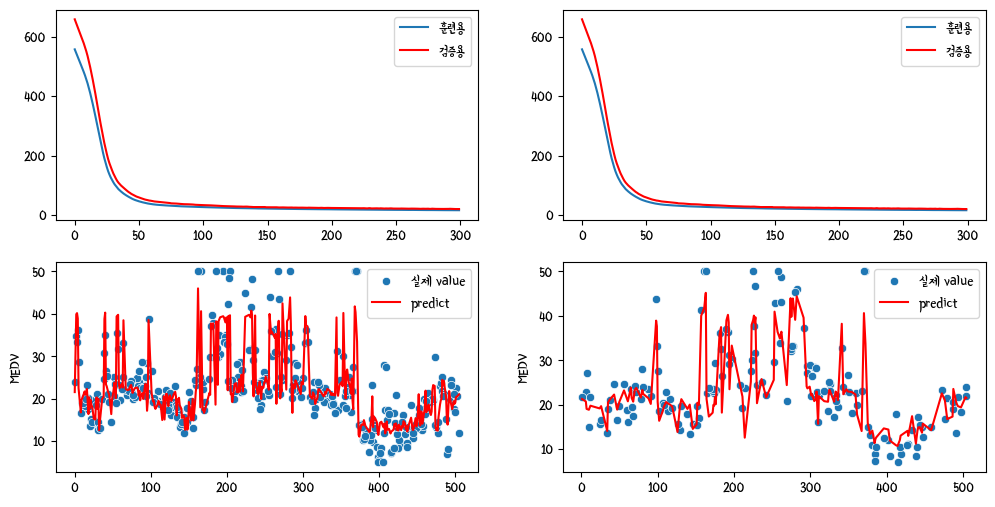

In [181]:
f,(a,b)=plt.subplots(2,2,figsize=(12,6))
# 손실률 <- 더 자세히 알아봐야하지만
sb.lineplot(x=range(len(results[2].history["loss"])),y=results[2].history["loss"],ax=a[0],label="훈련용")
sb.lineplot(x=range(len(results[2].history["val_loss"])),y=results[2].history["val_loss"],ax=a[0],color="red",label="검증용")
# MSE
sb.lineplot(x=range(len(results[2].history["mse"])),y=results[2].history["mse"],ax=a[1],label="훈련용")
sb.lineplot(x=range(len(results[2].history["val_mse"])),y=results[2].history["val_mse"],ax=a[1],color="red",label="검증용")
# 훈련용 데이터
sb.scatterplot(data=train,x=train.index,y=target,ax=b[0],label="실제 value")
sb.lineplot(data=train,x=train.index,y='pred_MEDV_2',ax=b[0],color="red",label="predict")
# 테스트 데이터
sb.scatterplot(data=test,x=test.index,y=target,ax=b[1],label="실제 value")
sb.lineplot(data=test,x=test.index,y='pred_MEDV_2',ax=b[1],color="red",label="predict")

#### 시각화 분석결과
- 1. 과적합 문제는 발생하지 않은것으로 보임 또한 충분한 변동성을 설명하고 있지만, 해석의 용이함을 위해선 RMSE를 사용하는 것이 더 나아보임.
- 2. 범주화 진행한 이상치가 많은 데이터에 대한 variance의 손실이 아쉬움 -> 개선할 방법을 생각해봐야함